# **2D CNN / Nehir Kırtaş**

# Data Preprocessing

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import zipfile

In [0]:
test_data_path = '/content/gdrive/My Drive/spec_data.zip'
# train_data_path = 'drive/My Drive/ml2/train.zip'
local_zip = test_data_path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('test')
zip_ref.close()

# CNN Model

In [0]:
import tensorflow as tf
from tensorflow.keras import regularizers

In [5]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(8, (5,5),activation='relu', input_shape=(400, 1000, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(8, (5,5),activation='relu'),

    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(16, (3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32, (3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 396, 996, 8)       608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 198, 498, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 198, 498, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 194, 494, 8)       1608      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 97, 247, 8)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 97, 247, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 95, 245, 16)       1

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
),
              metrics=['accuracy'])

# Performance Metrics Function

In [7]:
import torch
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

def report_performance(predictions, labels):
    genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
    
        
    if type(predictions).__module__ == torch.__name__ :
        predictions = predictions.tolist()
    if type(labels).__module__ == torch.__name__ :
        labels = labels.tolist()
    
    if type(predictions).__module__ == np.__name__ :
        predictions = list(predictions)
    if type(labels).__module__ == np.__name__ :
        labels = list(labels)
    

    
    size = len(genres);
    i = 0;
    
    while i < 10:
        if i in predictions:        
            for j, x in enumerate(predictions):
                if x == i:
                   predictions[j] = genres[i + size - 10]
        if i in labels:
            for j, x in enumerate(labels):
                if x == i: 
                    labels[j] = genres[i + size - 10]
        else: 
            del genres[i + size - 10]
            size -= 1
        i+=1; 
          

    data = {'y_Actual':    labels,
            'y_Predicted': predictions
            }
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
   
    sn.heatmap(confusion_matrix, annot=True)
    plt.show()
    print(classification_report(labels, predictions))
    
    cnf = multilabel_confusion_matrix(labels, predictions)

    for i in range(0, len(genres)):
        if (cnf[i][0][1]+cnf[i][1][1]) != 0:
            print("Accuracy for", genres[i], "is:", cnf[i][1][1]/(cnf[i][0][1]+cnf[i][1][1]), "\n")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Training and Evaluating Model

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255,validation_split = 0.20)
# test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        'test/mel_spec_data/', 
        target_size=(400, 1000),  
        batch_size=32,
        class_mode='categorical',
        subset="training")

validation_generator = train_datagen.flow_from_directory(
    'test/mel_spec_data/', # same directory as training data
    target_size=(400,1000),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

# test_generator = test_datagen.flow_from_directory(
#     'test/test',
#     target_size=(120,120),
#     batch_size=128,
#     class_mode='categorical',  
# ) 

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [9]:
# The first 25 epoch
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=25,
      validation_data = validation_generator, 
      validation_steps = 8,
      verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
8/8 [==============================] - 24s 3s/step - loss: 14.2358 - accuracy: 0.0703 - val_loss: 2.3036 - val_accuracy: 0.1078
Epoch 2/25
8/8 [==============================] - 24s 3s/step - loss: 2.5990 - accuracy: 0.1211 - val_loss: 2.3026 - val_accuracy: 0.0862
Epoch 3/25
8/8 [==============================] - 24s 3s/step - loss: 2.3094 - accuracy: 0.0938 - val_loss: 2.3024 - val_accuracy: 0.1207
Epoch 4/25
8/8 [==============================] - 23s 3s/step - loss: 2.3011 - accuracy: 0.1367 - val_loss: 2.3027 - val_accuracy: 0.1010
Epoch 5/25
8/8 [==============================] - 24s 3s/step - loss: 2.3025 - accuracy: 0.0977 - val_loss: 2.3026 - val_accuracy: 0.0991
Epoch 6/25
8/8 [==============================] - 24s 3s/step - loss: 2.3040 - accuracy: 0.0703 - val_loss: 2.3027 - val_accuracy: 0.0905
Epoch 7/25
8/8 [==============================] - 23s 3s/step - loss: 2.3034 - accuracy: 0.0625

Instructions for updating:
Please use Model.predict, which supports generators.


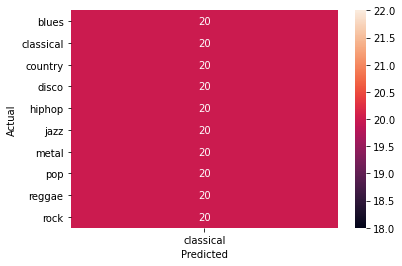

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        20
   classical       0.10      1.00      0.18        20
     country       0.00      0.00      0.00        20
       disco       0.00      0.00      0.00        20
      hiphop       0.00      0.00      0.00        20
        jazz       0.00      0.00      0.00        20
       metal       0.00      0.00      0.00        20
         pop       0.00      0.00      0.00        20
      reggae       0.00      0.00      0.00        20
        rock       0.00      0.00      0.00        20

    accuracy                           0.10       200
   macro avg       0.01      0.10      0.02       200
weighted avg       0.01      0.10      0.02       200

Accuracy for classical is: 0.1 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
labels = validation_generator.classes
steps = 200 / 32
predictions = model.predict_generator(validation_generator, steps)
predicted_classes = np.argmax(predictions, axis=1)
report_performance( predicted_classes, labels)

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [12]:
# The second 25 epoch
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=25,
      validation_data = validation_generator, 
      validation_steps = 8,
      verbose=1)

Epoch 1/25
8/8 [==============================] - 26s 3s/step - loss: 2.0966 - accuracy: 0.2305 - val_loss: 2.2812 - val_accuracy: 0.0991
Epoch 2/25
8/8 [==============================] - 25s 3s/step - loss: 2.1576 - accuracy: 0.2070 - val_loss: 2.2868 - val_accuracy: 0.1121
Epoch 3/25
8/8 [==============================] - 24s 3s/step - loss: 2.2349 - accuracy: 0.1328 - val_loss: 2.2933 - val_accuracy: 0.0962
Epoch 4/25
8/8 [==============================] - 25s 3s/step - loss: 2.1795 - accuracy: 0.2109 - val_loss: 2.3020 - val_accuracy: 0.0905
Epoch 5/25
8/8 [==============================] - 25s 3s/step - loss: 2.1557 - accuracy: 0.2109 - val_loss: 2.2028 - val_accuracy: 0.1121
Epoch 6/25
8/8 [==============================] - 24s 3s/step - loss: 1.9782 - accuracy: 0.2578 - val_loss: 2.1486 - val_accuracy: 0.1034
Epoch 7/25
8/8 [==============================] - 25s 3s/step - loss: 1.9152 - accuracy: 0.2891 - val_loss: 2.1441 - val_accuracy: 0.1379
Epoch 8/25
8/8 [==================

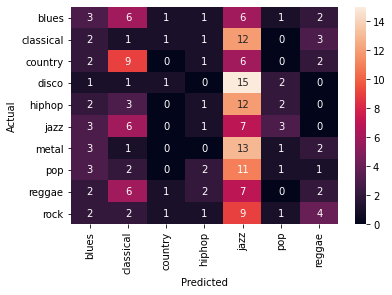

              precision    recall  f1-score   support

       blues       0.13      0.15      0.14        20
   classical       0.03      0.05      0.04        20
     country       0.00      0.00      0.00        20
       disco       0.00      0.00      0.00        20
      hiphop       0.10      0.05      0.07        20
        jazz       0.07      0.35      0.12        20
       metal       0.00      0.00      0.00        20
         pop       0.09      0.05      0.06        20
      reggae       0.12      0.10      0.11        20
        rock       0.00      0.00      0.00        20

    accuracy                           0.07       200
   macro avg       0.05      0.07      0.05       200
weighted avg       0.05      0.07      0.05       200

Accuracy for blues is: 0.13043478260869565 

Accuracy for classical is: 0.02702702702702703 

Accuracy for country is: 0.0 

Accuracy for hiphop is: 0.1 

Accuracy for jazz is: 0.07142857142857142 

Accuracy for pop is: 0.09090909090909091 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
labels = validation_generator.classes
steps = 200 / 32
predictions = model.predict_generator(validation_generator, steps)
predicted_classes = np.argmax(predictions, axis=1)
report_performance( predicted_classes, labels)

In [0]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']
loss += history.history['loss']
val_loss += history.history['val_loss']

In [15]:
# The third 25 epoch
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=25,
      validation_data = validation_generator, 
      validation_steps = 8,
      verbose=1)

Epoch 1/25
8/8 [==============================] - 25s 3s/step - loss: 1.5131 - accuracy: 0.4297 - val_loss: 1.8938 - val_accuracy: 0.3491
Epoch 2/25
8/8 [==============================] - 23s 3s/step - loss: 1.2056 - accuracy: 0.6172 - val_loss: 1.7438 - val_accuracy: 0.3846
Epoch 3/25
8/8 [==============================] - 25s 3s/step - loss: 1.2563 - accuracy: 0.5781 - val_loss: 1.8156 - val_accuracy: 0.4181
Epoch 4/25
8/8 [==============================] - 25s 3s/step - loss: 1.1376 - accuracy: 0.6211 - val_loss: 1.8897 - val_accuracy: 0.2974
Epoch 5/25
8/8 [==============================] - 23s 3s/step - loss: 1.2551 - accuracy: 0.5625 - val_loss: 1.8236 - val_accuracy: 0.3621
Epoch 6/25
8/8 [==============================] - 24s 3s/step - loss: 1.1634 - accuracy: 0.6094 - val_loss: 1.9322 - val_accuracy: 0.3190
Epoch 7/25
8/8 [==============================] - 24s 3s/step - loss: 0.9383 - accuracy: 0.6992 - val_loss: 1.7849 - val_accuracy: 0.4009
Epoch 8/25
8/8 [==================

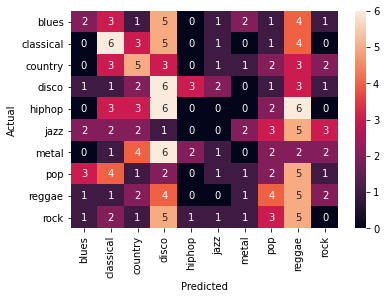

              precision    recall  f1-score   support

       blues       0.20      0.10      0.13        20
   classical       0.23      0.30      0.26        20
     country       0.21      0.25      0.23        20
       disco       0.14      0.30      0.19        20
      hiphop       0.00      0.00      0.00        20
        jazz       0.00      0.00      0.00        20
       metal       0.00      0.00      0.00        20
         pop       0.10      0.10      0.10        20
      reggae       0.12      0.25      0.16        20
        rock       0.00      0.00      0.00        20

    accuracy                           0.13       200
   macro avg       0.10      0.13      0.11       200
weighted avg       0.10      0.13      0.11       200

Accuracy for blues is: 0.2 

Accuracy for classical is: 0.23076923076923078 

Accuracy for country is: 0.20833333333333334 

Accuracy for disco is: 0.13953488372093023 

Accuracy for hiphop is: 0.0 

Accuracy for jazz is: 0.0 

Accuracy for 

In [16]:
labels = validation_generator.classes
steps = 200 / 32
predictions = model.predict_generator(validation_generator, steps)
predicted_classes = np.argmax(predictions, axis=1)
report_performance( predicted_classes, labels)

In [0]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']
loss += history.history['loss']
val_loss += history.history['val_loss']

In [18]:
# The fourth 25 epoch
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=25,
      validation_data = validation_generator, 
      validation_steps = 8,
      verbose=1)

Epoch 1/25
8/8 [==============================] - 24s 3s/step - loss: 0.1834 - accuracy: 0.9492 - val_loss: 1.7734 - val_accuracy: 0.4808
Epoch 2/25
8/8 [==============================] - 25s 3s/step - loss: 0.1762 - accuracy: 0.9648 - val_loss: 2.0942 - val_accuracy: 0.4526
Epoch 3/25
8/8 [==============================] - 25s 3s/step - loss: 0.1391 - accuracy: 0.9570 - val_loss: 1.7156 - val_accuracy: 0.5216
Epoch 4/25
8/8 [==============================] - 24s 3s/step - loss: 0.1581 - accuracy: 0.9531 - val_loss: 2.2050 - val_accuracy: 0.4828
Epoch 5/25
8/8 [==============================] - 25s 3s/step - loss: 0.1044 - accuracy: 0.9727 - val_loss: 1.8435 - val_accuracy: 0.5259
Epoch 6/25
8/8 [==============================] - 26s 3s/step - loss: 0.1510 - accuracy: 0.9375 - val_loss: 2.0932 - val_accuracy: 0.4440
Epoch 7/25
8/8 [==============================] - 26s 3s/step - loss: 0.1141 - accuracy: 0.9609 - val_loss: 1.9247 - val_accuracy: 0.5259
Epoch 8/25
8/8 [==================

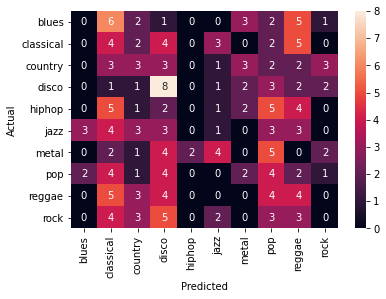

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        20
   classical       0.11      0.20      0.14        20
     country       0.15      0.15      0.15        20
       disco       0.21      0.40      0.28        20
      hiphop       0.00      0.00      0.00        20
        jazz       0.08      0.05      0.06        20
       metal       0.00      0.00      0.00        20
         pop       0.12      0.20      0.15        20
      reggae       0.13      0.20      0.16        20
        rock       0.00      0.00      0.00        20

    accuracy                           0.12       200
   macro avg       0.08      0.12      0.09       200
weighted avg       0.08      0.12      0.09       200

Accuracy for blues is: 0.0 

Accuracy for classical is: 0.10526315789473684 

Accuracy for country is: 0.15 

Accuracy for disco is: 0.21052631578947367 

Accuracy for hiphop is: 0.0 

Accuracy for jazz is: 0.07692307692307693 

Accuracy for

In [19]:
labels = validation_generator.classes
steps = 200 / 32
predictions = model.predict_generator(validation_generator, steps)
predicted_classes = np.argmax(predictions, axis=1)
report_performance( predicted_classes, labels)

In [0]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']
loss += history.history['loss']
val_loss += history.history['val_loss']

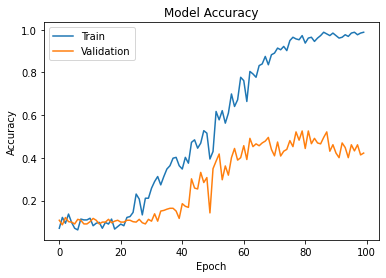

In [22]:
# summarize history for accuracy
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

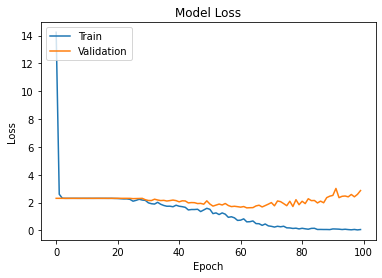

In [23]:
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()